# Annotation

## Environment setup

We'll filter out some deprecation and performance warnings that do not affect our code:

In [1]:
import os

import pandas as pd

os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

Load the needed modules:

In [2]:
import scanpy as sc
import re
import anndata as ad
import torch
import h5py
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

 captum (see https://github.com/pytorch/captum).


In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

if not os.path.exists("analysis/"):
    os.mkdir("analysis/")

## Load data

Load in allen brain atlas reference data

In [5]:
f = h5py.File("objects/GSE185862_expression_matrix_10x.hdf5", "r")
for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key])) # get the object type: usually group or dataset

data
<class 'h5py._hl.group.Group'>


In [6]:
#Get the HDF5 group; key needs to be a group name from above
group = f[key]

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)
    
source_adata = group["counts"][()]
genes = group["gene"][()]
cells = group["samples"][()]

#After you are done
f.close()

counts
gene
samples
shape


In [7]:
source_adata = ad.AnnData(source_adata.T)
source_adata.obs_names = cells.astype("str")
source_adata.var_names = genes.astype("str")
source_adata

AnnData object with n_obs × n_vars = 1169320 × 31053

Load in metadata and match to expression matrix rows

In [8]:
metadata = pd.read_csv("objects/GSE185862_metadata_10x.csv")
metadata = metadata.set_index("sample_name")
metadata.reindex(index=cells)
metadata = metadata.reset_index()
metadata = metadata.set_index("sample_name")
metadata

Unnamed: 0  donor_sex_id donor_sex_label  \
sample_name                                                                     
ACGCAGCAGACCGGAT-L8TX_180221_01_C11           1             2               M   
CCATGTCAGCGCTTAT-L8TX_180221_01_C11           2             2               M   
GCGCAGTAGTGTCTCA-L8TX_180712_01_H05           3             2               M   
GTCACGGCACCAACCG-L8TX_180712_01_H05           4             2               M   
ATTGGACTCGATCCCT-L8TX_180712_01_A06           5             2               M   
...                                         ...           ...             ...   
TTTGTCATCACCACCT-L8TX_180115_01_E08     1169209             2               M   
TTTGTCATCCCAAGTA-L8TX_180115_01_E08     1169210             2               M   
TTTGTCATCCTCAACC-L8TX_180115_01_E08     1169211             2               M   
TTTGTCATCGACAGCC-L8TX_180115_01_E08     1169212             2               M   
TTTGTCATCGTGGTCG-L8TX_180115_01_E08     1169213             2               M   

                                    donor_sex_color  region_id  region_label  \
sample_name                                                                    
ACGCAGCAGACCGGAT-L8TX_180221_01_C11         #ADC4C3         20           RSP   
CCATGTCAGCGCTTAT-L8TX_180221_01_C11         #ADC4C3         20           RSP   
GCGCAGTAGTGTCTCA-L8TX_180712_01_H05         #ADC4C3         21  TEa-PERI-ECT   
GTCACGGCACCAACCG-L8TX_180712_01_H05         #ADC4C3         21  TEa-PERI-ECT   
ATTGGACTCGATCCCT-L8TX_180712_01_A06         #ADC4C3         21  TEa-PERI-ECT   
...                                             ...        ...           ...   
TTTGTCATCACCACCT-L8TX_180115_01_E08         #ADC4C3          1          VISp   
TTTGTCATCCCAAGTA-L8TX_180115_01_E08         #ADC4C3          1          VISp   
TTTGTCATCCTCAACC-L8TX_180115_01_E08         #ADC4C3          1          VISp   
TTTGTCATCGACAGCC-L8TX_180115_01_E08         #ADC4C3          1          VISp   
TTTGTCATCGTGGTCG-L8TX_180115_01_E08         #ADC4C3          1          VISp   

                                    region_color platform_label  \
sample_name                                                       
ACGCAGCAGACCGGAT-L8TX_180221_01_C11      #2B9EAD            10X   
CCATGTCAGCGCTTAT-L8TX_180221_01_C11      #2B9EAD            10X   
GCGCAGTAGTGTCTCA-L8TX_180712_01_H05      #76CBE2            10X   
GTCACGGCACCAACCG-L8TX_180712_01_H05      #76CBE2            10X   
ATTGGACTCGATCCCT-L8TX_180712_01_A06      #76CBE2            10X   
...                                          ...            ...   
TTTGTCATCACCACCT-L8TX_180115_01_E08      #9299FF            10X   
TTTGTCATCCCAAGTA-L8TX_180115_01_E08      #9299FF            10X   
TTTGTCATCCTCAACC-L8TX_180115_01_E08      #9299FF            10X   
TTTGTCATCGACAGCC-L8TX_180115_01_E08      #9299FF            10X   
TTTGTCATCGTGGTCG-L8TX_180115_01_E08      #9299FF            10X   

                                     cluster_order    cluster_label  ...  \
sample_name                                                          ...   
ACGCAGCAGACCGGAT-L8TX_180221_01_C11            116        116_Pvalb  ...   
CCATGTCAGCGCTTAT-L8TX_180221_01_C11            364           364_DG  ...   
GCGCAGTAGTGTCTCA-L8TX_180712_01_H05             18         18_Lamp5  ...   
GTCACGGCACCAACCG-L8TX_180712_01_H05             15         15_Lamp5  ...   
ATTGGACTCGATCCCT-L8TX_180712_01_A06             18         18_Lamp5  ...   
...                                            ...              ...  ...   
TTTGTCATCACCACCT-L8TX_180115_01_E08             59    59_Vip Igfbp6  ...   
TTTGTCATCCCAAGTA-L8TX_180115_01_E08            168  168_L2/3 IT CTX  ...   
TTTGTCATCCTCAACC-L8TX_180115_01_E08            168  168_L2/3 IT CTX  ...   
TTTGTCATCGACAGCC-L8TX_180115_01_E08            227    227_L6 IT CTX  ...   
TTTGTCATCGTGGTCG-L8TX_180115_01_E08            196    196_L5 IT CTX  ...   

                                    cell_type_alias_id  \
sample_name            

Remove metadata cells not in the expression matrix, and visa versa

In [9]:
metadata = metadata[metadata.index.isin(source_adata.obs_names)]

In [10]:
source_adata = source_adata[source_adata.obs_names.isin(metadata.index)]
source_adata

View of AnnData object with n_obs × n_vars = 1169213 × 31053

Now lets make metadata columns match the cells in the expression matrix

In [11]:
metadata = metadata.reindex(source_adata.obs_names)

In [12]:
metadata

Unnamed: 0  donor_sex_id donor_sex_label  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09      205690             2               M   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09      205691             2               M   
AAACCTGAGAGTAATC-L8TX_180221_01_F09      205692             2               M   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09      205693             2               M   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09      205694             2               M   
...                                         ...           ...             ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05        6791             1               F   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05      131312             1               F   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05      131313             1               F   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05       17906             1               F   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05      131314             1               F   

                                    donor_sex_color  region_id  region_label  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGAGTAATC-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09         #ADC4C3         19           ACA   
...                                             ...        ...           ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   

                                    region_color platform_label  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGAGTAATC-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09      #FFDE17            10X   
...                                          ...            ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05      #76CBE2            10X   

                                     cluster_order    cluster_label  ...  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09            168  168_L2/3 IT CTX  ...   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09            168  168_L2/3 IT CTX  ...   
AAACCTGAGAGTAATC-L8TX_180221_01_F09            189  189_L4/5 IT CTX  ...   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09            290    290_L6 CT CTX  ...   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09            265  265_L5/6 NP CTX  ...   
...                                            ...              ...  ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05             18         18_Lamp5  ...   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05            265  265_L5/6 NP CTX  ...   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05            162  162_L2/3 IT CTX  ...   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05             68           68_Sst  ...   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05            282    282_L6 CT CTX  ...   

                                    cell_type_alias_id  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09                168   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09                168   
AAACCTGAGAGTAATC-L8TX_180221_01_F09                189   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09                290   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09                265   
...                                  

Now lets add this metadata to the anndata

In [13]:
source_adata.obs = metadata
source_adata.obs

Unnamed: 0  donor_sex_id donor_sex_label  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09      205690             2               M   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09      205691             2               M   
AAACCTGAGAGTAATC-L8TX_180221_01_F09      205692             2               M   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09      205693             2               M   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09      205694             2               M   
...                                         ...           ...             ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05        6791             1               F   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05      131312             1               F   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05      131313             1               F   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05       17906             1               F   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05      131314             1               F   

                                    donor_sex_color  region_id  region_label  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGAGTAATC-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09         #ADC4C3         19           ACA   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09         #ADC4C3         19           ACA   
...                                             ...        ...           ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05         #565353         21  TEa-PERI-ECT   

                                    region_color platform_label  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGAGTAATC-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09      #FFDE17            10X   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09      #FFDE17            10X   
...                                          ...            ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05      #76CBE2            10X   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05      #76CBE2            10X   

                                     cluster_order    cluster_label  ...  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09            168  168_L2/3 IT CTX  ...   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09            168  168_L2/3 IT CTX  ...   
AAACCTGAGAGTAATC-L8TX_180221_01_F09            189  189_L4/5 IT CTX  ...   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09            290    290_L6 CT CTX  ...   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09            265  265_L5/6 NP CTX  ...   
...                                            ...              ...  ...   
TTTGTCAGTCGCGGTT-L8TX_200611_02_A05             18         18_Lamp5  ...   
TTTGTCAGTCTAGGTT-L8TX_200611_02_A05            265  265_L5/6 NP CTX  ...   
TTTGTCAGTGAGGCTA-L8TX_200611_02_A05            162  162_L2/3 IT CTX  ...   
TTTGTCATCAGGCGAA-L8TX_200611_02_A05             68           68_Sst  ...   
TTTGTCATCGTCTGAA-L8TX_200611_02_A05            282    282_L6 CT CTX  ...   

                                    cell_type_alias_id  \
AAACCTGAGAAACGCC-L8TX_180221_01_F09                168   
AAACCTGAGAAGGTTT-L8TX_180221_01_F09                168   
AAACCTGAGAGTAATC-L8TX_180221_01_F09                189   
AAACCTGAGCCTTGAT-L8TX_180221_01_F09                290   
AAACCTGAGTGGTAAT-L8TX_180221_01_F09                265   
...                                  

Lets check some basic QC and filtering

In [14]:
sc.pp.filter_cells(source_adata, min_genes=100)
sc.pp.filter_genes(source_adata, min_cells=100)

In [15]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
source_adata.var["mt"] = source_adata.var_names.str.startswith("mt-")
# ribosomal genes
source_adata.var["ribo"] = source_adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
source_adata.var["hb"] = source_adata.var_names.str.contains("^Hb[^(P)]")

sc.pp.calculate_qc_metrics(
    source_adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

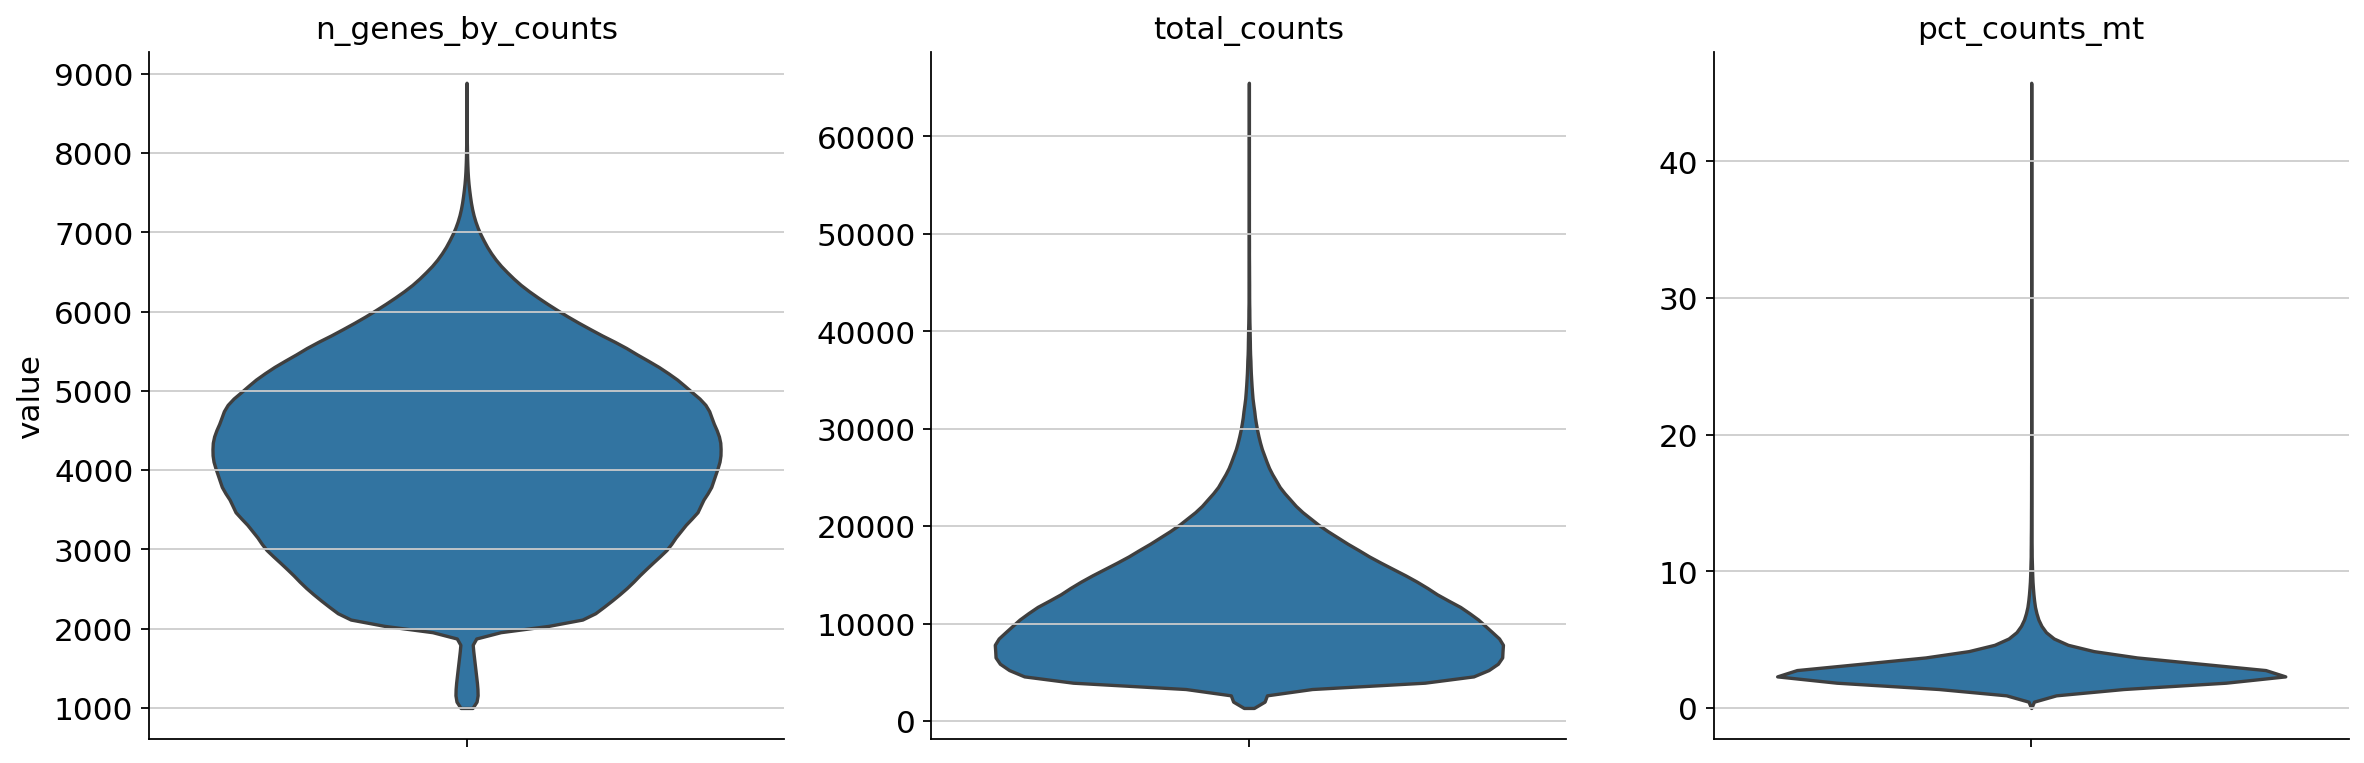

In [16]:
sc.pl.violin(
    source_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot=False,
    multi_panel=True,
)

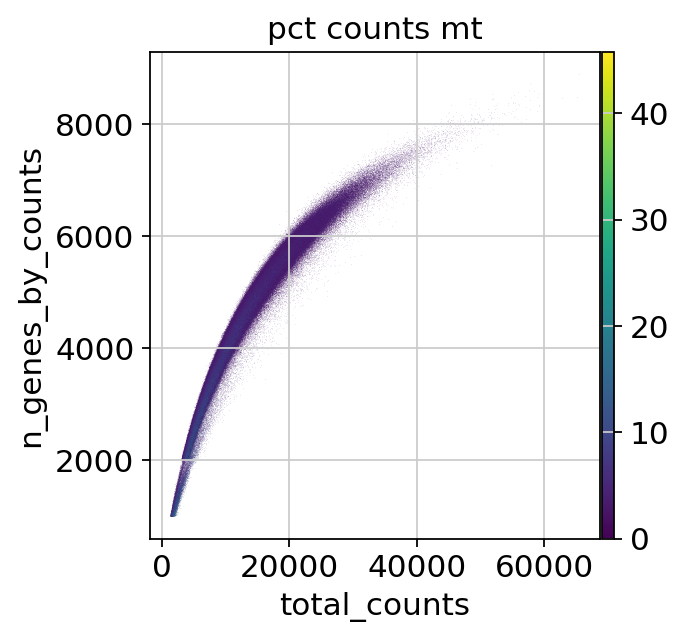

In [17]:
sc.pl.scatter(source_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Find Variable Genes

In [18]:
source_adata.layers["counts"] = source_adata.X.copy()

In [19]:
# Normalizing to median total counts
sc.pp.normalize_total(source_adata)
# Logarithmize the data
sc.pp.log1p(source_adata)
sc.pp.highly_variable_genes(source_adata, n_top_genes=3000)

Subset to HVGs

In [20]:
source_adata = source_adata[:,source_adata.var.highly_variable].copy()

Revert to raw counts

In [21]:
source_adata.X = source_adata.layers["counts"]
del source_adata.layers["counts"]

Now lets make a cell type column to transfer the annotations

In [22]:
source_adata.obs["cell_type"] = source_adata.obs.cluster_label.str.extract(r'[^_]*_(.*)')

In [26]:
source_adata.write_h5ad("analysis/source_adata.h5ad")

## Create scVI model and train it on reference dataset

Set settings

In [7]:
source_adata.obs["batch"] = 1
sca.models.SCVI.setup_anndata(source_adata, batch_key="batch")

Create the scVI model instance with NB loss as default. Insert “recon_loss=’mse’,” or “recon_loss=’zinb’,” to change the reconstruction loss

In [8]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

Train

In [9]:
vae.train()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 7/7: 100%|██████████| 7/7 [1:04:46<00:00, 391.55s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.1e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=7` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 7/7: 100%|██████████| 7/7 [1:04:46<00:00, 555.16s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.1e+3]


Lets get the reference latent embedding for later

In [10]:
ref_emb = sc.AnnData(X=vae.get_latent_representation(), obs=source_adata.obs)
ref_emb.obs["reference_or_query"] = "reference"

In [11]:
ref_path="analysis/refscVI"
vae.save(ref_path, overwrite=True)

Let's read in the data pre-processed in R

## Automated annotation

### Annotation by mapping to a reference

scArches, which we will use as an example of reference-mapping-based label transfer, takes as its basis an existing (variational autoencoder-based) model that embeds the reference data in a low-dimensional, batch-corrected space. It then slightly extends that model to enable the mapping of an unseen dataset into the same "latent space" (i.e. the low-dimensional embedding). This model extension also enables the learning and removal of batch effects present in the mapped dataset.

We will now show how to map data to a reference using scArches and use this mapping to perform label transfer from the reference to the new data ("query").
```{admonition} Warning
Note that scArches does not run, or runs very slowly if you do not have access to a GPU. You might therefore need to run this part of the notebook from a computing cluster/server.
```

Let's start by preparing our data for the mapping to a reference. scArches, the method that enables us to adapt an existing reference model to new data requires raw, non-normalized counts. We will therefore keep our counts layer and remove all other layers from our adata to map. We will set our .X to those raw counts as well.

In [6]:
source_adata = sc.read_h5ad("analysis/source_adata.h5ad")

In [12]:
ref_path="analysis/refscVI"

In [14]:
adata = sc.read_h5ad("objects/Multiome.h5ad")

In [15]:
adata_to_map = adata.copy()
for layer in list(adata_to_map.layers.keys()):
    if layer != "counts":
        del adata_to_map.layers[layer]

Lets see if we are missing any needed genes in the query dataset

In [16]:
print(
    "Percent of needed genes found in query dataset:",
    100*(adata_to_map.var_names.isin(source_adata.var_names).sum()/len(source_adata.var_names)),
)

Percent of needed genes found in query dataset: 93.23333333333333


Lets add rows of 0s for the missing genes

In [17]:
missing_genes = [
    gene
    for gene in source_adata.var_names
    if gene not in adata_to_map.var_names
]

In [18]:
from scipy.sparse import csr_matrix
missing_gene_adata = sc.AnnData(
    X=csr_matrix(np.zeros(shape=(adata.n_obs, len(missing_genes))), dtype="float32"),
    obs=adata.obs.iloc[:, :],
)
missing_gene_adata.var.index = missing_genes

Concatenate our original adata to the missing genes adata. To make sure we can do this concatenation without errors, we’ll remove the PCA matrix from varm.

In [19]:
if "PCs" in adata_to_map.varm.keys():
    del adata_to_map.varm["PCs"]

In [20]:
adata_to_map = sc.concat(
    [adata_to_map, missing_gene_adata],
    axis=1,
    join="outer",
    index_unique=None,
    merge="unique",
)

In [21]:
print(
    "Percent of needed genes found in query dataset:",
    100*(adata_to_map.var_names.isin(source_adata.var_names).sum()/len(source_adata.var_names)),
)

Percent of needed genes found in query dataset: 100.0


In [22]:
adata_to_map = adata_to_map[
    :, source_adata.var_names
].copy()

Check genes match

In [23]:
(adata_to_map.var.index == source_adata.var.index).all()

True

In [24]:
# Remove source adata as we no longer need it
del source_adata

Need to add a batch column

In [25]:
adata_to_map.obs["batch"] = 2

In [26]:
new_vae = sca.models.SCVI.load_query_data(
    adata=adata_to_map,
    reference_model=ref_path,
    freeze_dropout=True,
)

INFO     File analysis/refscVI/model.pt already downloaded                                                         


We will now update this reference model so that we can embed our own data (the "query") in the same latent space as the reference. This requires training on our query data using scArches:

In [27]:
new_vae.train(max_epochs=500, plan_kwargs=dict(weight_decay=0.0))

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|██████████| 500/500 [17:31<00:00,  2.13s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.17e+3]

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [17:31<00:00,  2.10s/it, v_num=1, train_loss_step=1.16e+3, train_loss_epoch=1.17e+3]


Now that we have updated the model, we can calculate the (ideally batch-corrected) latent representation of our query:

In [28]:
adata.obsm["scVI"] = new_vae.get_latent_representation()

We can now use this newly calculated low-dimensional embedding as a basis for visualization and clustering. Let's calculate the new UMAP using the scVI-based representation of the data.

In [29]:
sc.pp.neighbors(adata, use_rep="scVI")
sc.tl.umap(adata)

To see if the mapping-based UMAP makes general sense, let's look at a few markers and if their expression is localized to specific parts of the UMAP:

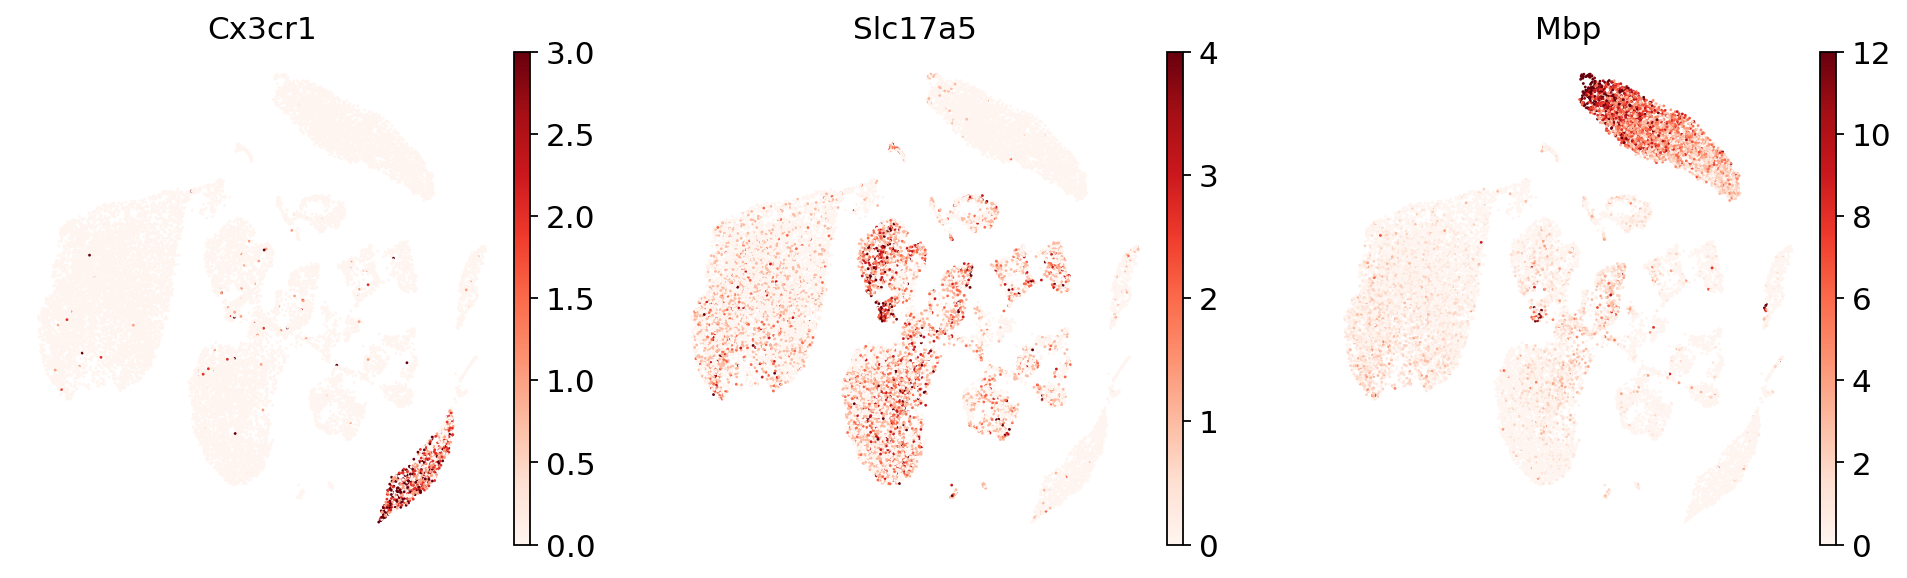

In [30]:
sc.pl.umap(
    adata,
    color=["Cx3cr1", "Slc17a5", "Mbp"],
    vmin=0,
    vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
    sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
    frameon=False,
    cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
)

Now the essential step is that we can combine the inferred latent space embedding of our query data with the existing reference embedding. Using this joint embedding, we will not only be able to e.g. visualize and cluster the two together, but we can also do label transfer from the query to the reference.<br> 
Let's load the reference embedding: this is often made publicly available with existing atlases.

To perform the label transfer, we will first concatenate the reference and query data using the 10-dimensional embedding. To get there, we will create the same type of AnnData object from our query data as we have from the reference (with the embedding under `.X`) and concatenate the two. With that, we can jointly analyze reference and query including doing transfer from one to the other.

In [31]:
adata_emb = sc.AnnData(X=adata.obsm["scVI"], obs=adata.obs)

In [32]:
adata_emb.obs["reference_or_query"] = "query"

In [33]:
emb_ref_query = sc.concat(
    [ref_emb, adata_emb],
    axis=0,
    join="outer",
    index_unique=None,
    merge="unique",
)

Let's visualize the joint embedding with a UMAP.

In [34]:
sc.pp.neighbors(emb_ref_query)
sc.tl.umap(emb_ref_query)

We can visually get a first impression of whether the reference and query integrated well based on the UMAP:

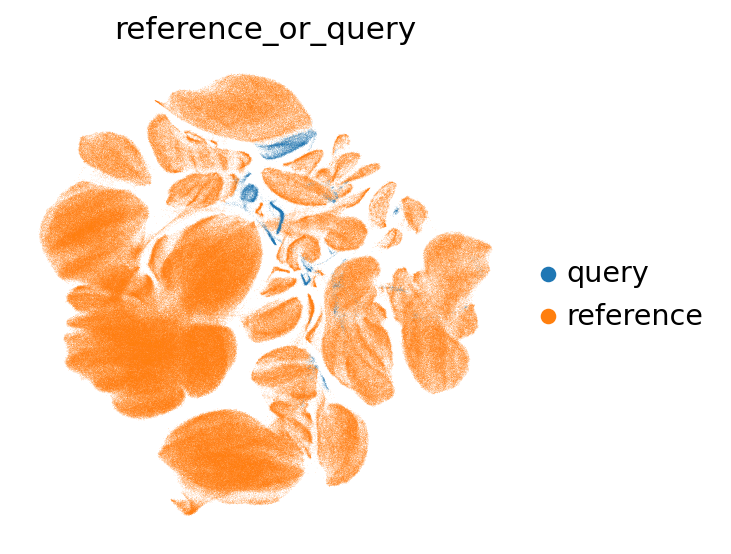

In [35]:
sc.pl.umap(
    emb_ref_query,
    color=["reference_or_query"],
    sort_order=False,
    frameon=False,
)

The (partial) mixing of query and reference in this UMAP is a good sign! When mapping completely fails, you will often see a full separation of query and reference in the UMAP.

Now let's look at the cell type annotations from the reference. All cells from the query are set to NA here as they don't have annotations yet and shown in black.

We'll make this figure a bit bigger so that we can read the legend well:

In [36]:
sc.set_figure_params(figsize=(10, 10))

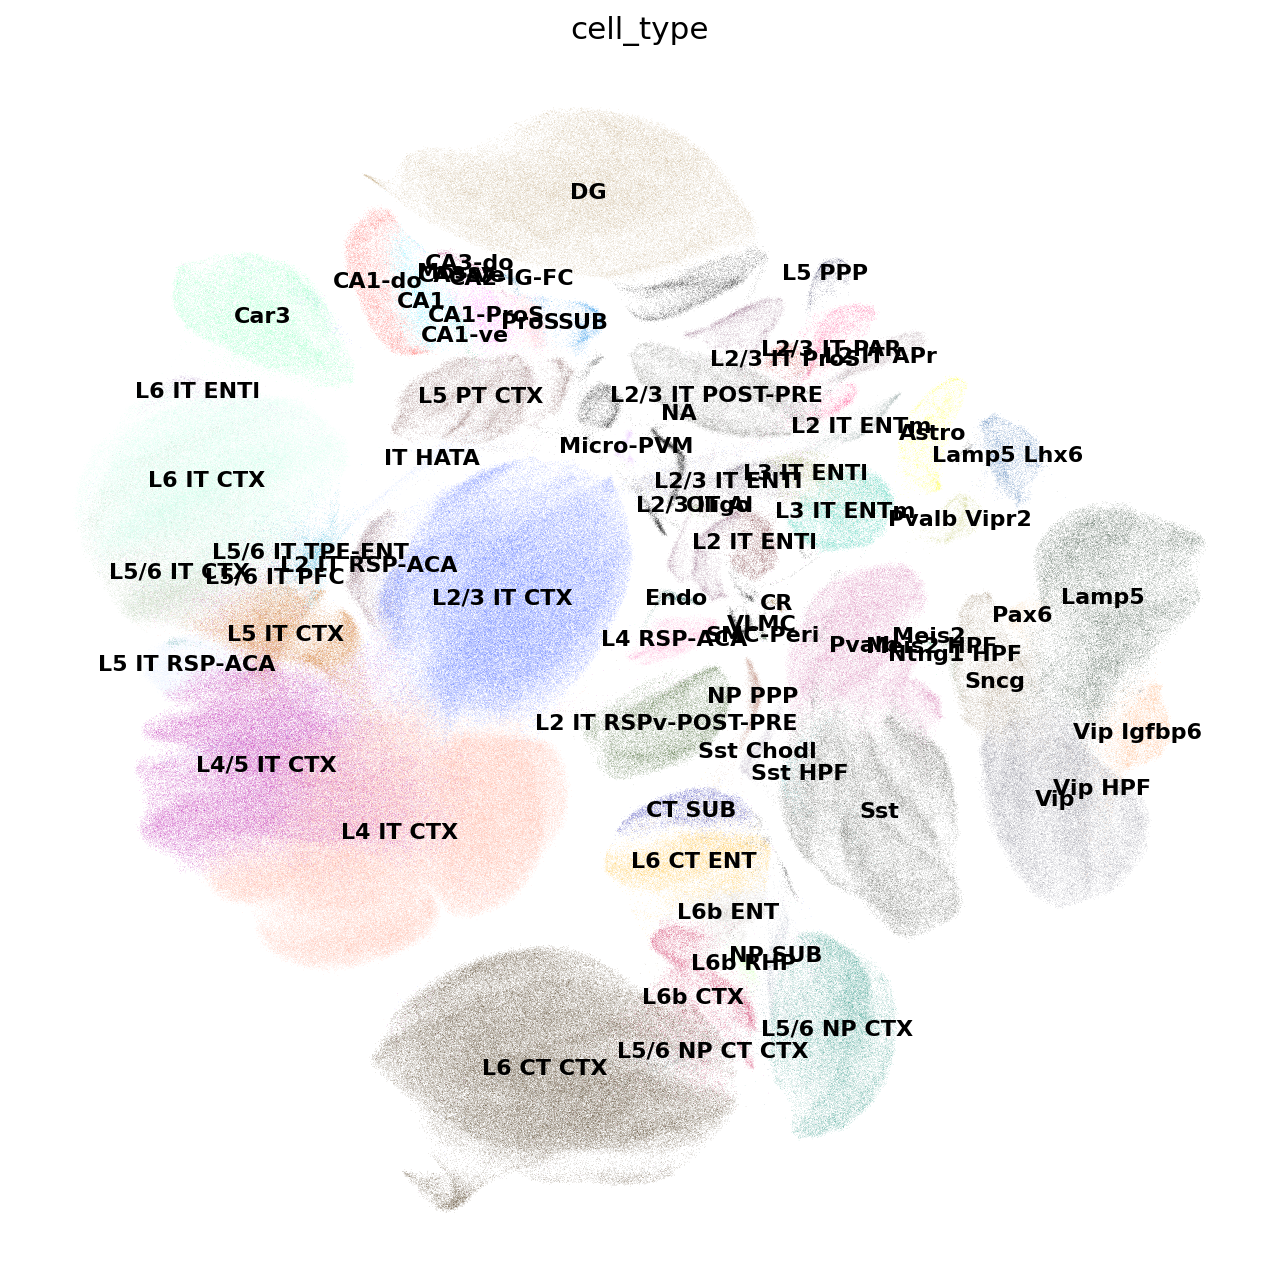

In [37]:
sc.pl.umap(
    emb_ref_query,
    color=["cell_type"],
    sort_order=False,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=10,
    na_color="black",
)

As you can already tell from the UMAP, we can guess the cell type of each of our own cells (in black) by looking at which cell types from the reference surround it. This is exactly what a nearest-neighbor-graph-based label transfer approach does: for each query cell it checks what is the most common cell type among its neighboring reference cells. The higher the fraction of reference cells coming from a single cell type, the more confident the label transfer is.

Let's perform the KNN-based label transfer. 

First we set up the label transfer model:

In [38]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=ref_emb,
    train_adata_emb="X",  # location of our joint embedding
    n_neighbors=15,
)

Weighted KNN with n_neighbors = 15 ... 

Now we perform the label transfer:

In [39]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_emb,
    query_adata_emb="X",  # location of our embedding, query_adata.X in this case
    label_keys="cell_type",  # (start of) obs column name(s) for which to transfer labels
    knn_model=knn_transformer,
    ref_adata_obs=ref_emb.obs,
)

finished!


And store the results in our adata:

In [40]:
adata_emb.obs["transf_cell_type"] = labels.loc[adata_emb.obs.index, "cell_type"]
adata_emb.obs["transf_cell_type_unc"] = uncert.loc[adata_emb.obs.index, "cell_type"]

Let's transfer the results to our query adata object which also has our UMAP and gene counts, so that we can visualize all of those together.

In [41]:
adata.obs.loc[adata_emb.obs.index, "transf_cell_type"] = adata_emb.obs[
    "transf_cell_type"
]
adata.obs.loc[adata_emb.obs.index, "transf_cell_type_unc"] = adata_emb.obs[
    "transf_cell_type_unc"
]

We can now visualize the transferred labels in our previously calculated UMAP of our own data:

Let's set the figure size smaller again:

In [42]:
sc.set_figure_params(figsize=(15, 15))

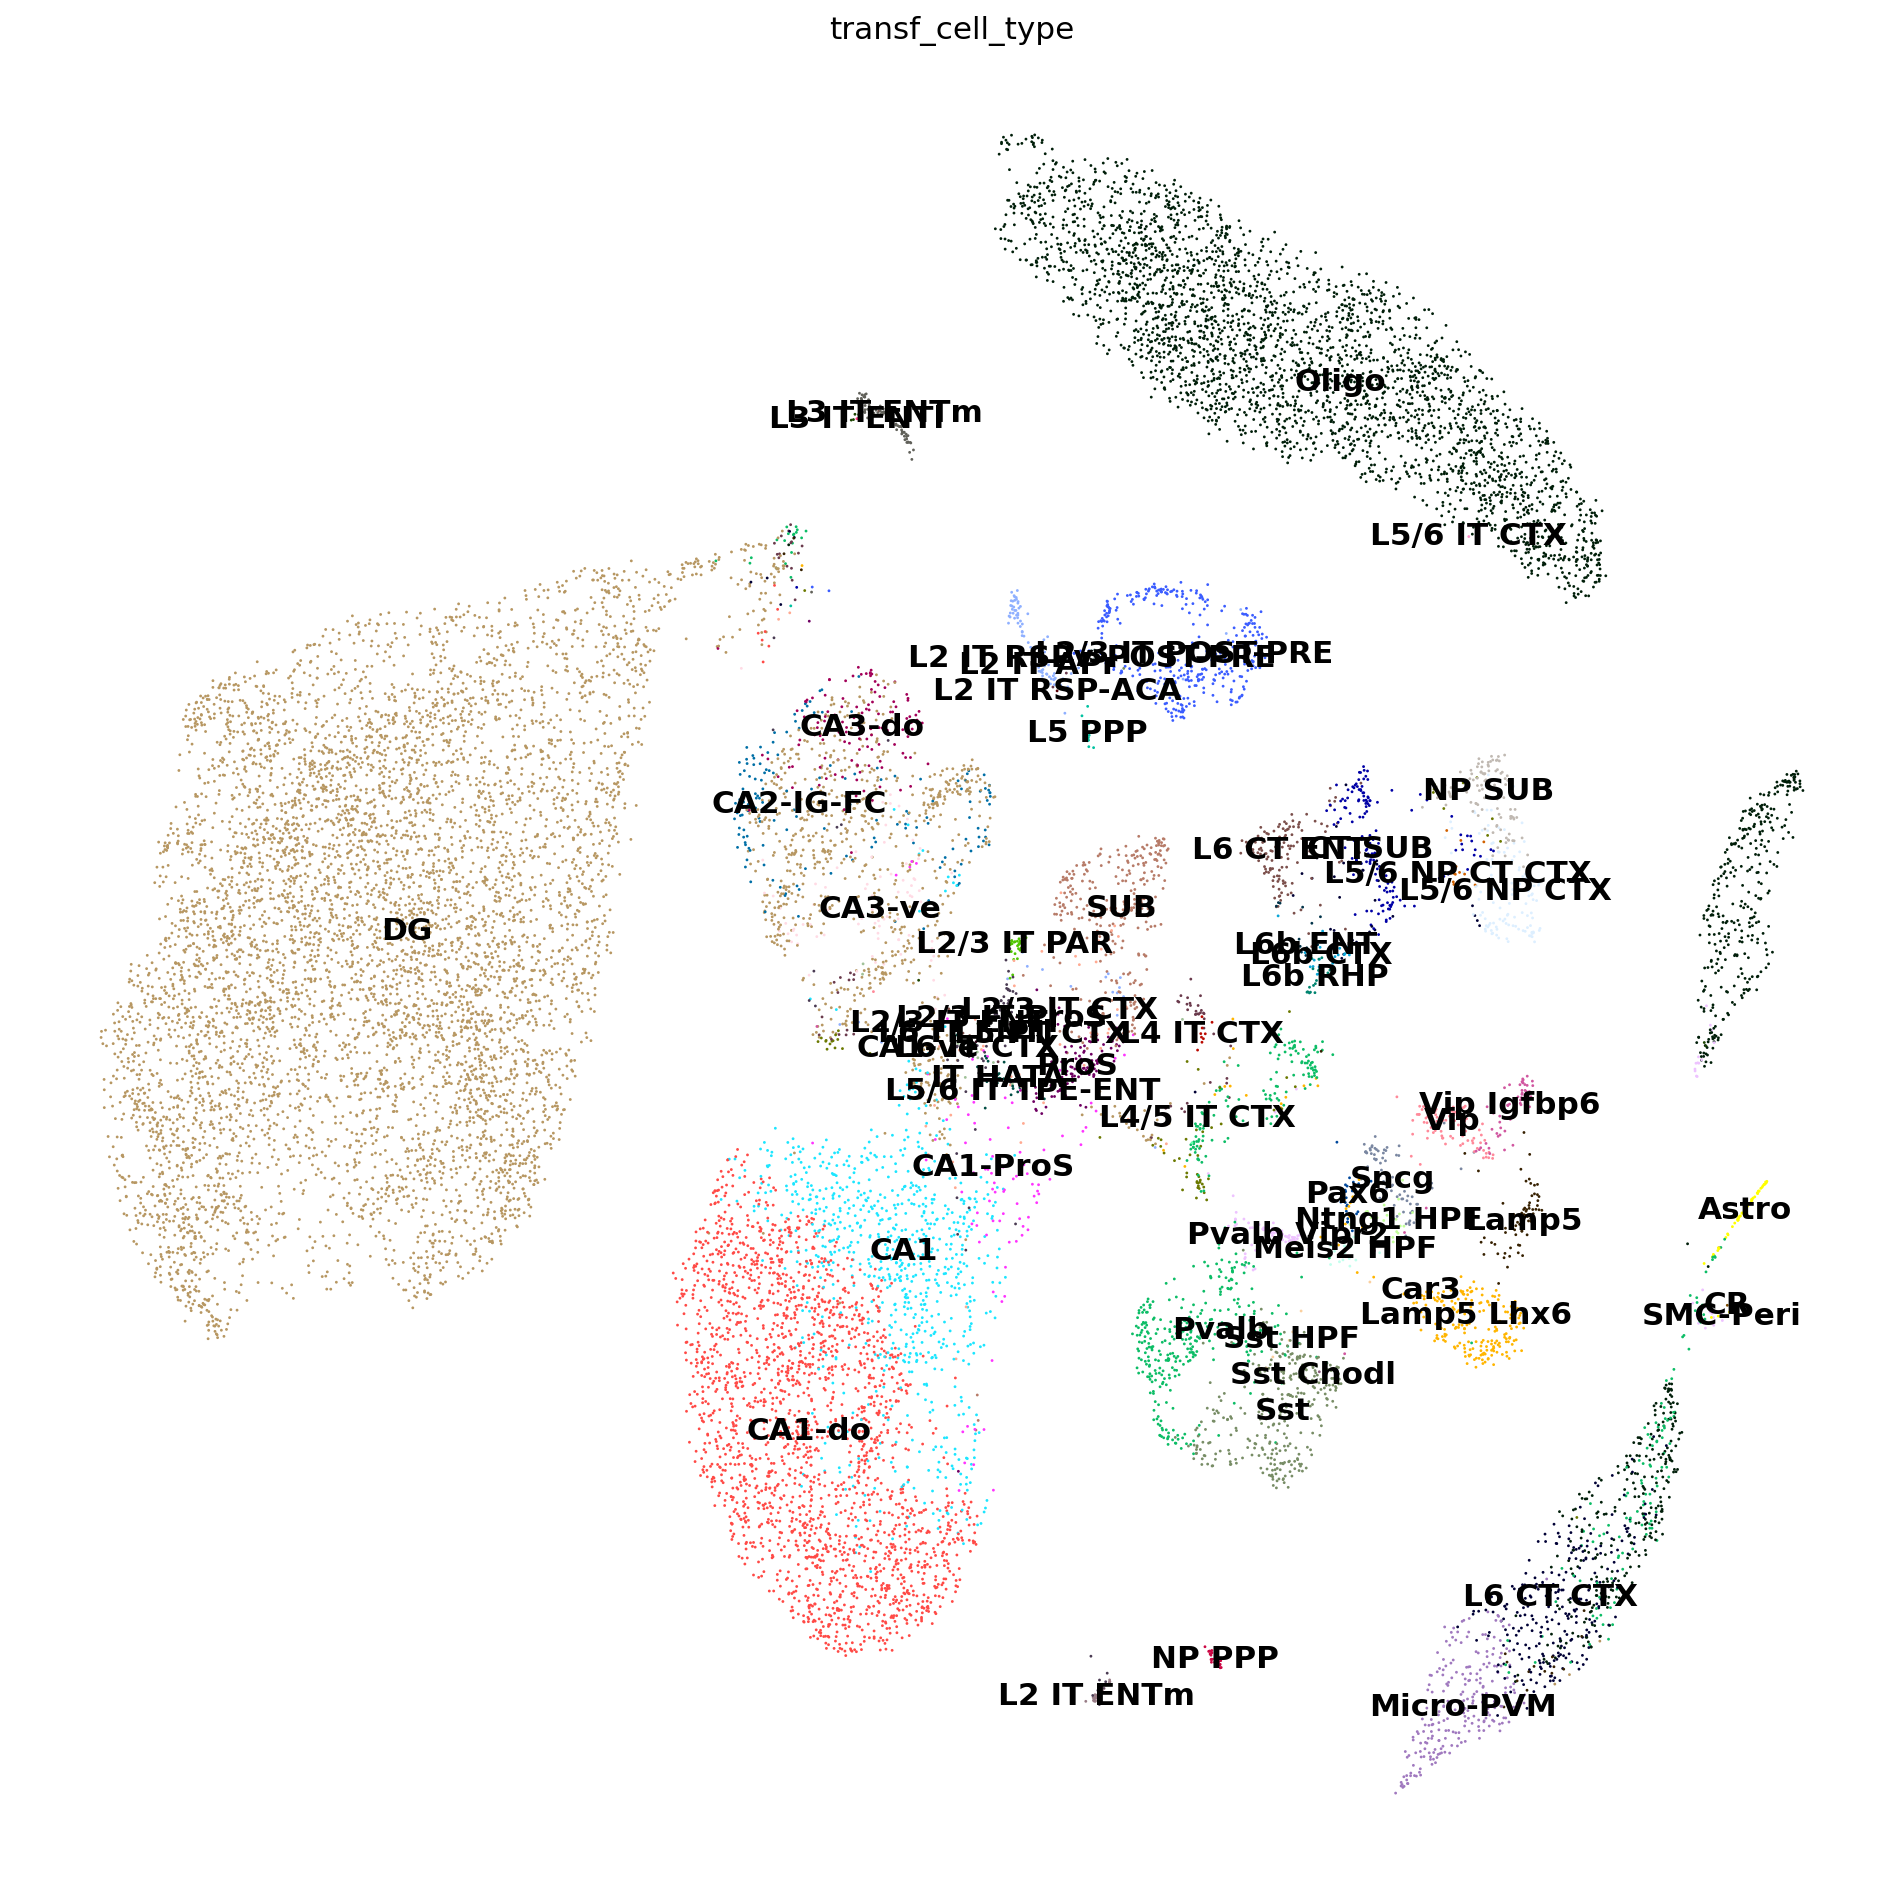

In [43]:
sc.pl.umap(adata, color="transf_cell_type", frameon=False, legend_loc="on data")

Based on the neighbors of each of our query cells we can not only guess the cell type these cells belong to, but also generate a measure for certainty of that label: if a cell has neighbors from several different cell types, our guess will be highly uncertain. This is relevant to assess to what extent we can "trust" the transferred labels! Let's visualize the uncertainty scores:

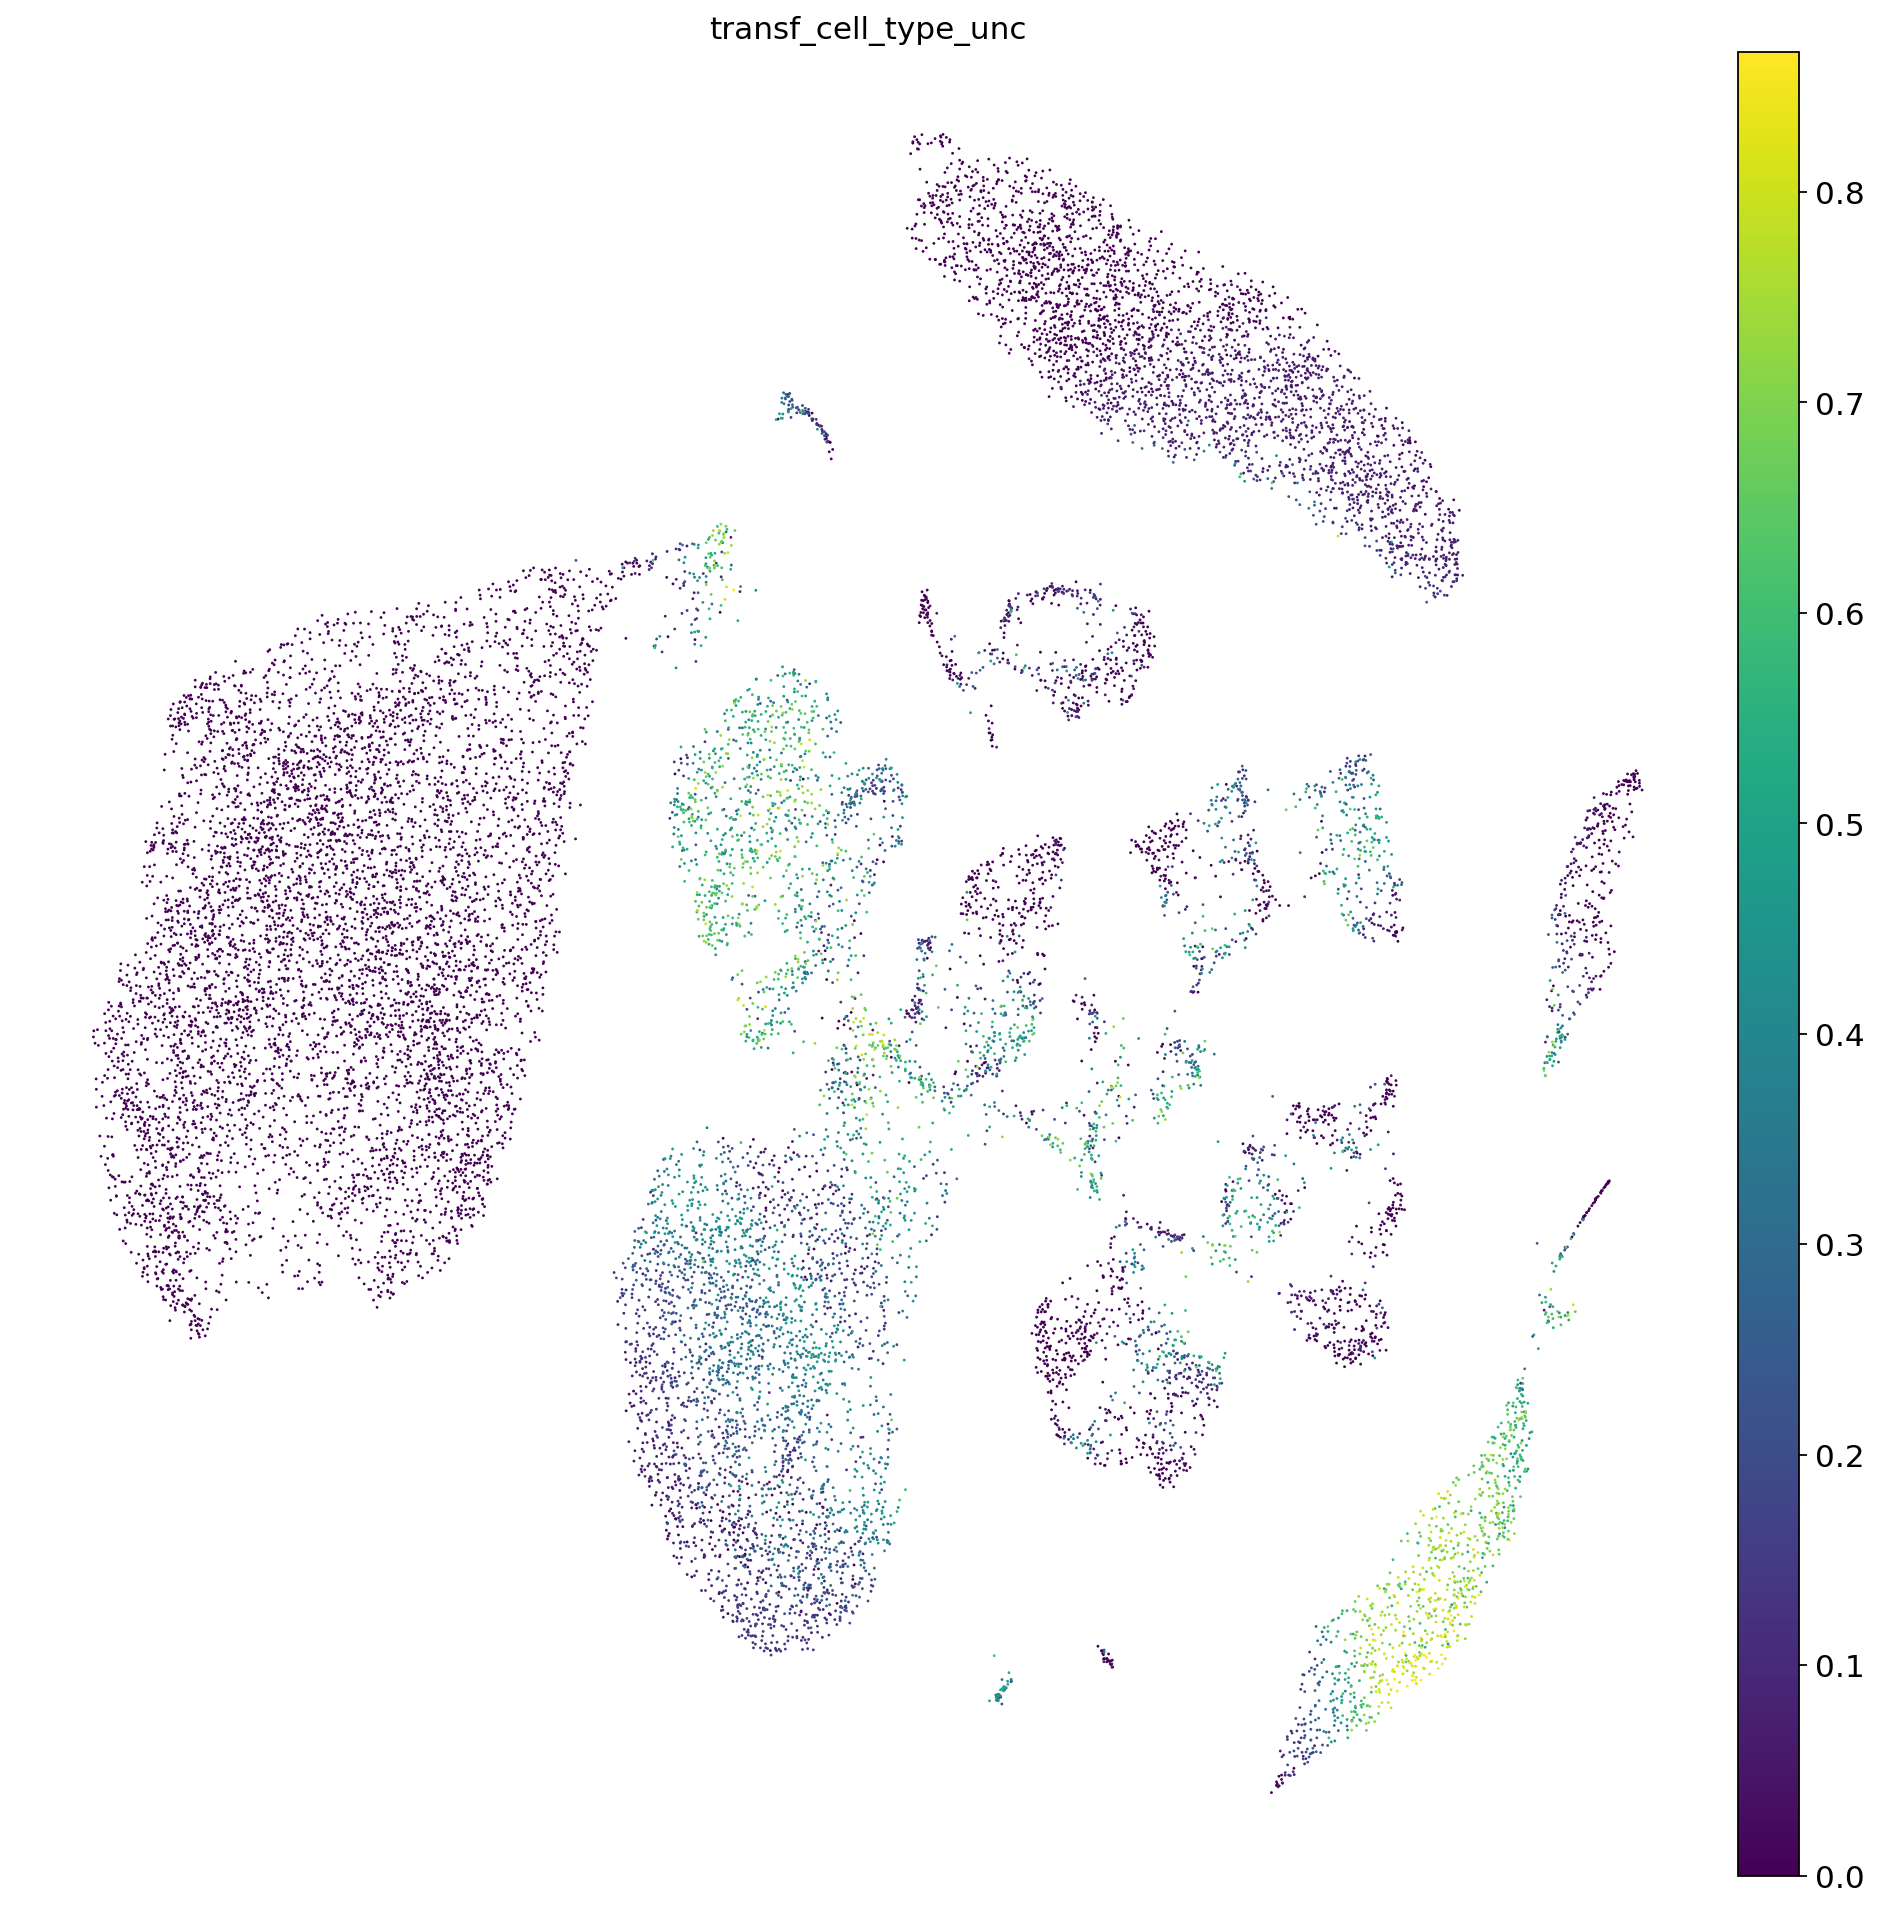

In [44]:
sc.pl.umap(adata, color="transf_cell_type_unc", frameon=False)

Let's check for each cell type label how high the label transfer uncertainty levels were. This gives us a first impression of which annotations are more contentious/need more manual checks.

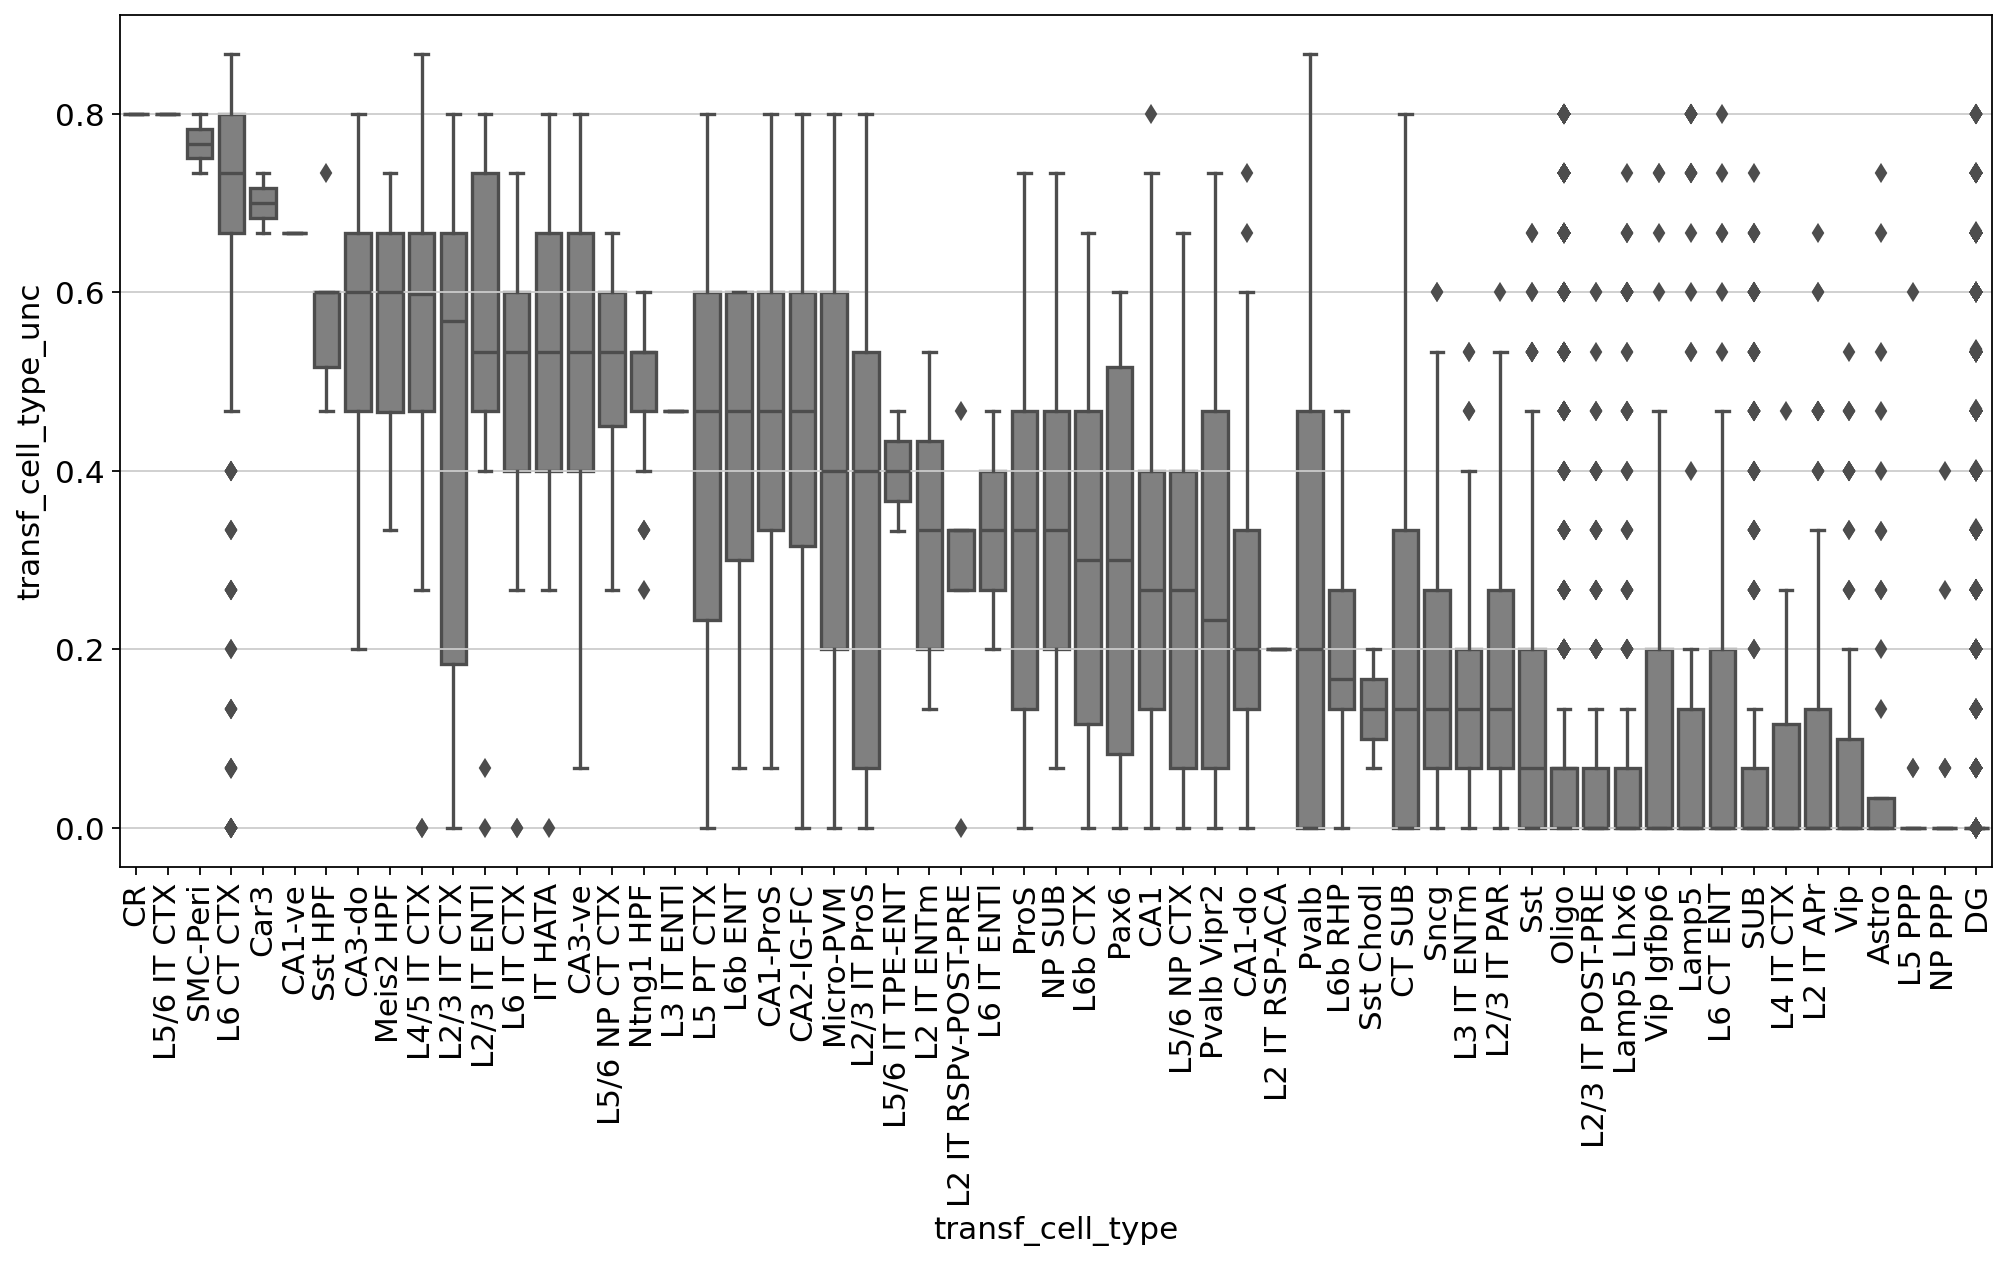

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 7))
ct_order = (
    adata.obs.groupby("transf_cell_type")
    .agg({"transf_cell_type_unc": "median"})
    .sort_values(by="transf_cell_type_unc", ascending=False)
)
sns.boxplot(
    adata.obs,
    x="transf_cell_type",
    y="transf_cell_type_unc",
    color="grey",
    ax=ax,
    order=ct_order.index,
)
ax.tick_params(rotation=90, axis="x")

##### You'll notice that e.g. progenitor cells are often more difficult to distinguish than other cell types. Same for the rather unspecific category "Other T" cells in our annotations. All the way on the right we see pDCs, a cell type that is known to be quite transcriptionally distinct and therefore easier to recognize and label.

##### To incorporate this uncertainty information in our transferred labels, we can set cells with an uncertainty score above e.g. 0.2 to "unknown":

In [46]:
adata.obs["transf_cell_type_certain"] = adata.obs.transf_cell_type.tolist()
adata.obs.loc[
    adata.obs.transf_cell_type_unc > 0.2, "transf_cell_type_certain"
] = "Unknown"

Let's see what our annotations look like after this filtering. Note the Unknown color in the legend and the UMAP.

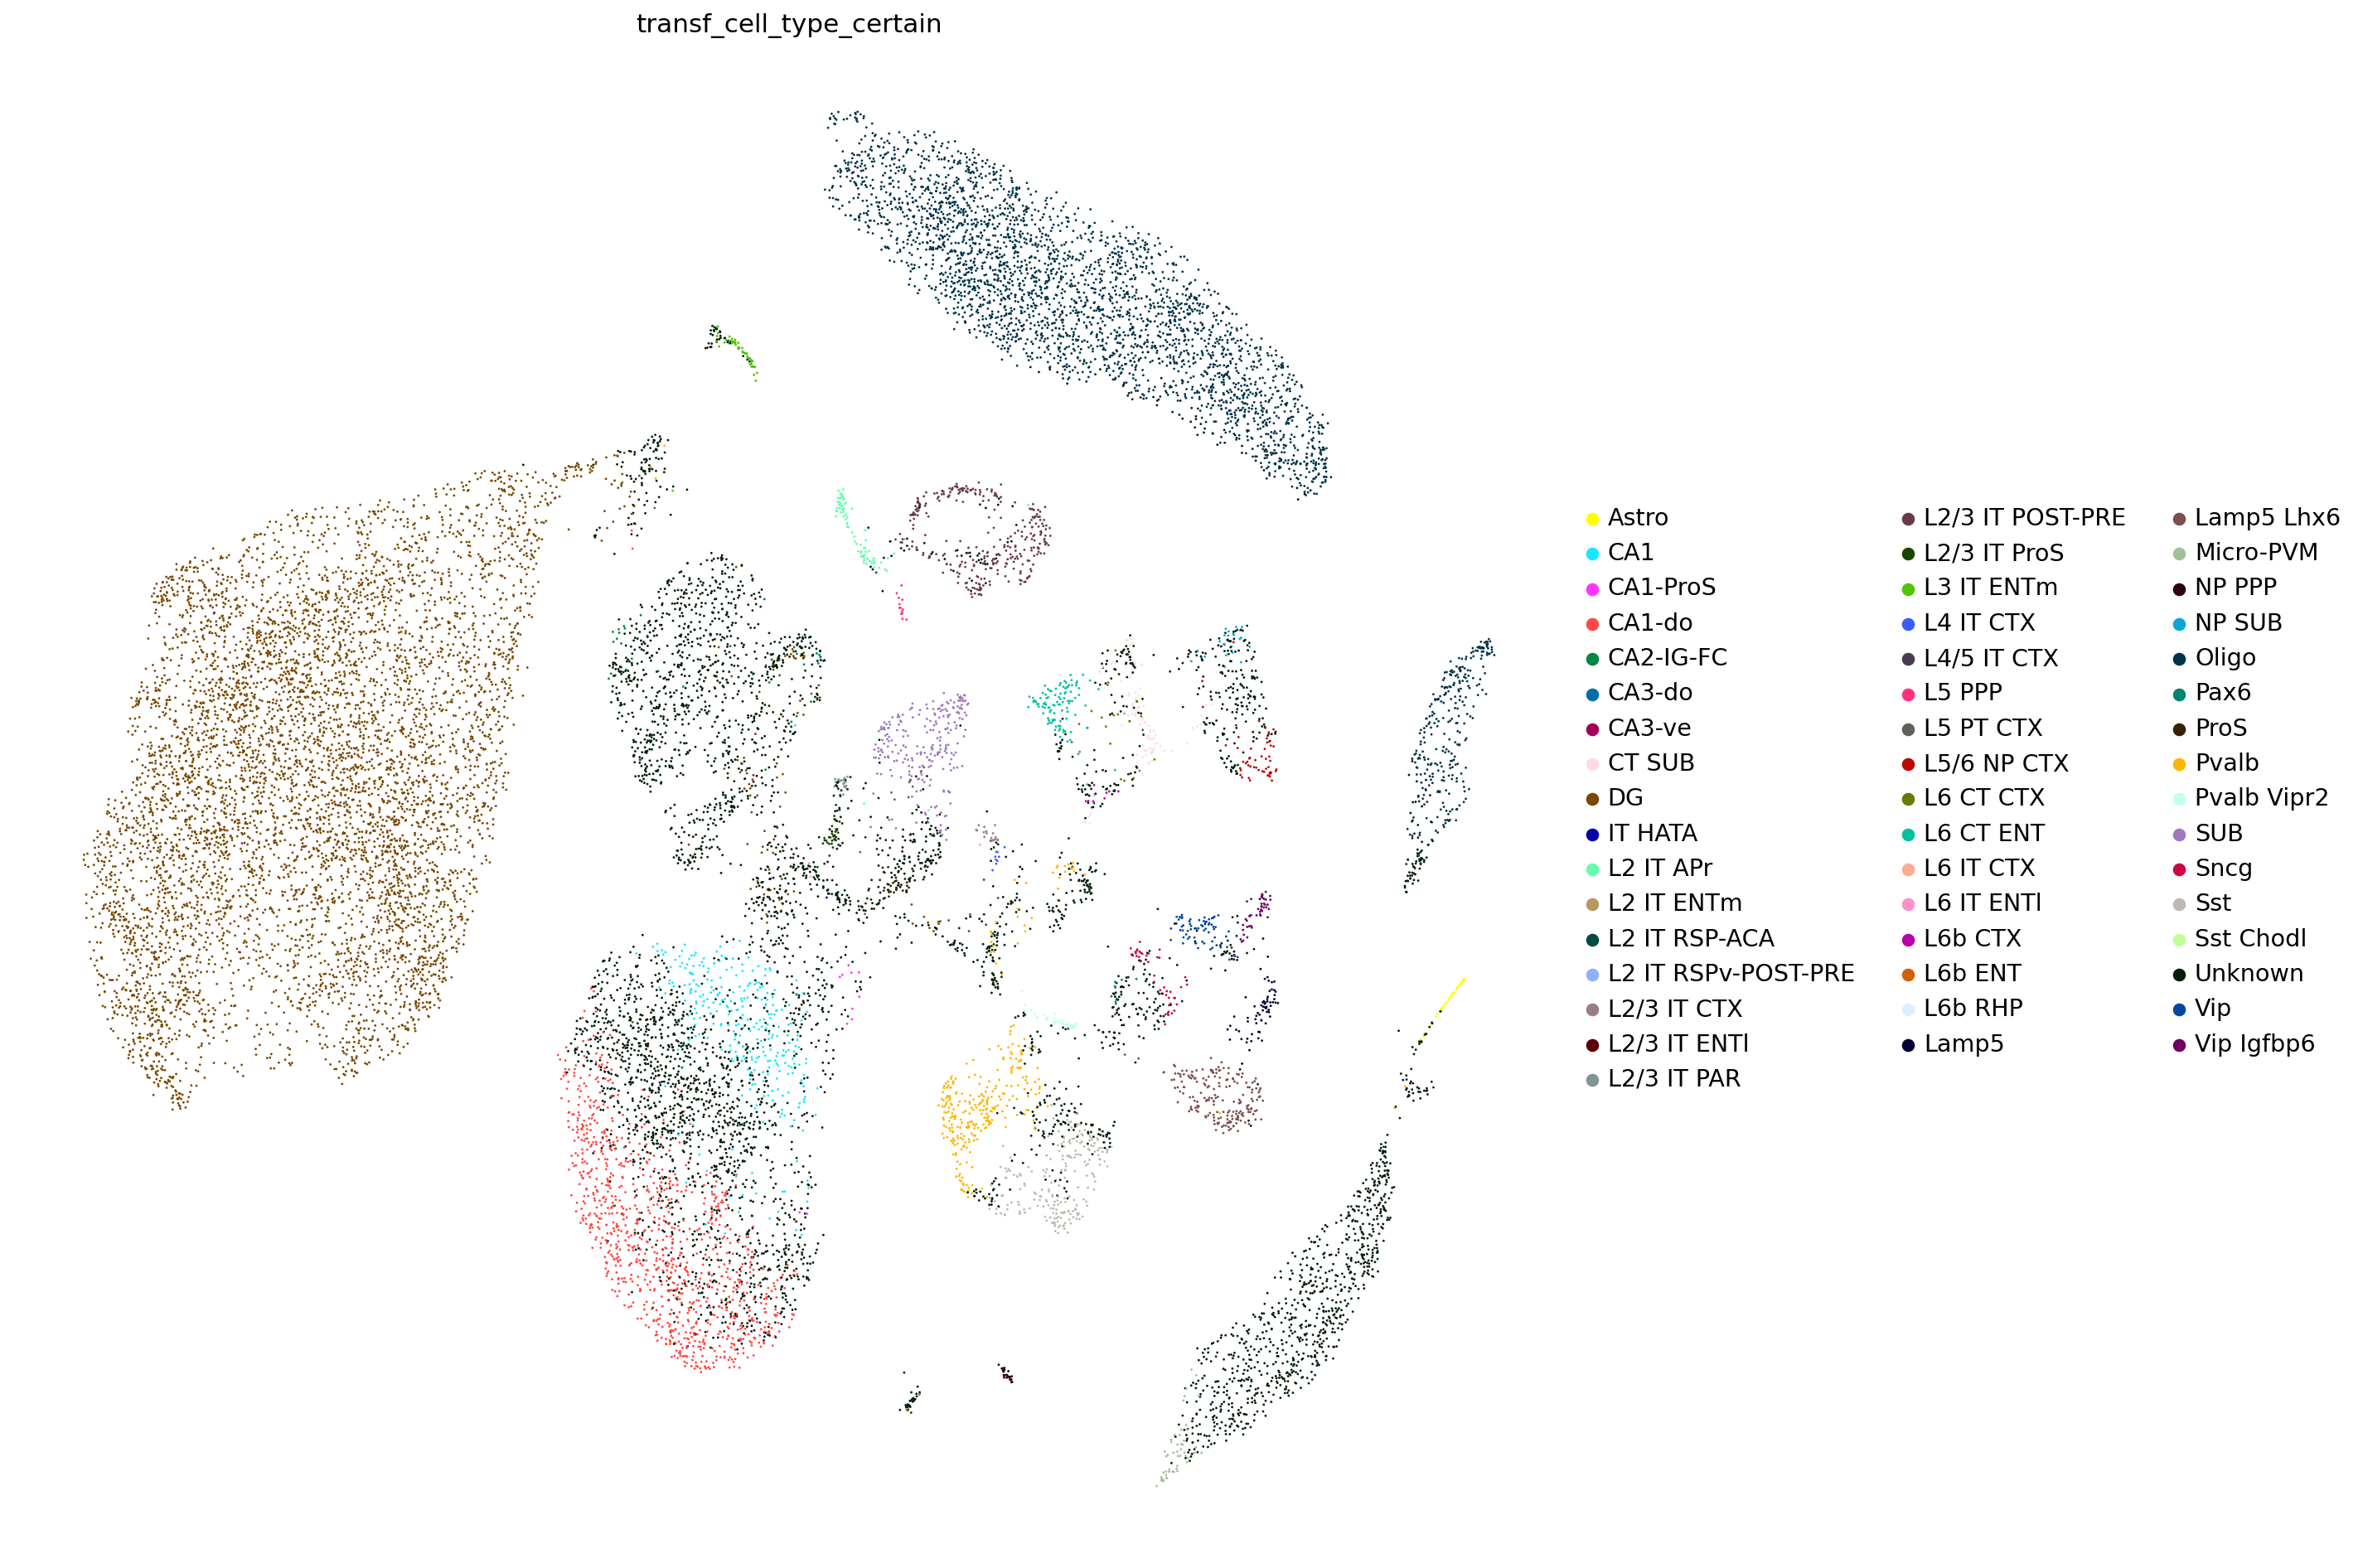

In [47]:
sc.pl.umap(adata, color="transf_cell_type_certain", frameon=False)

To ease legibility, we can color *only* the "unknown" cells. This will make it easier for us to see how many of those there are. You can do the same with any of the other cell type labels.

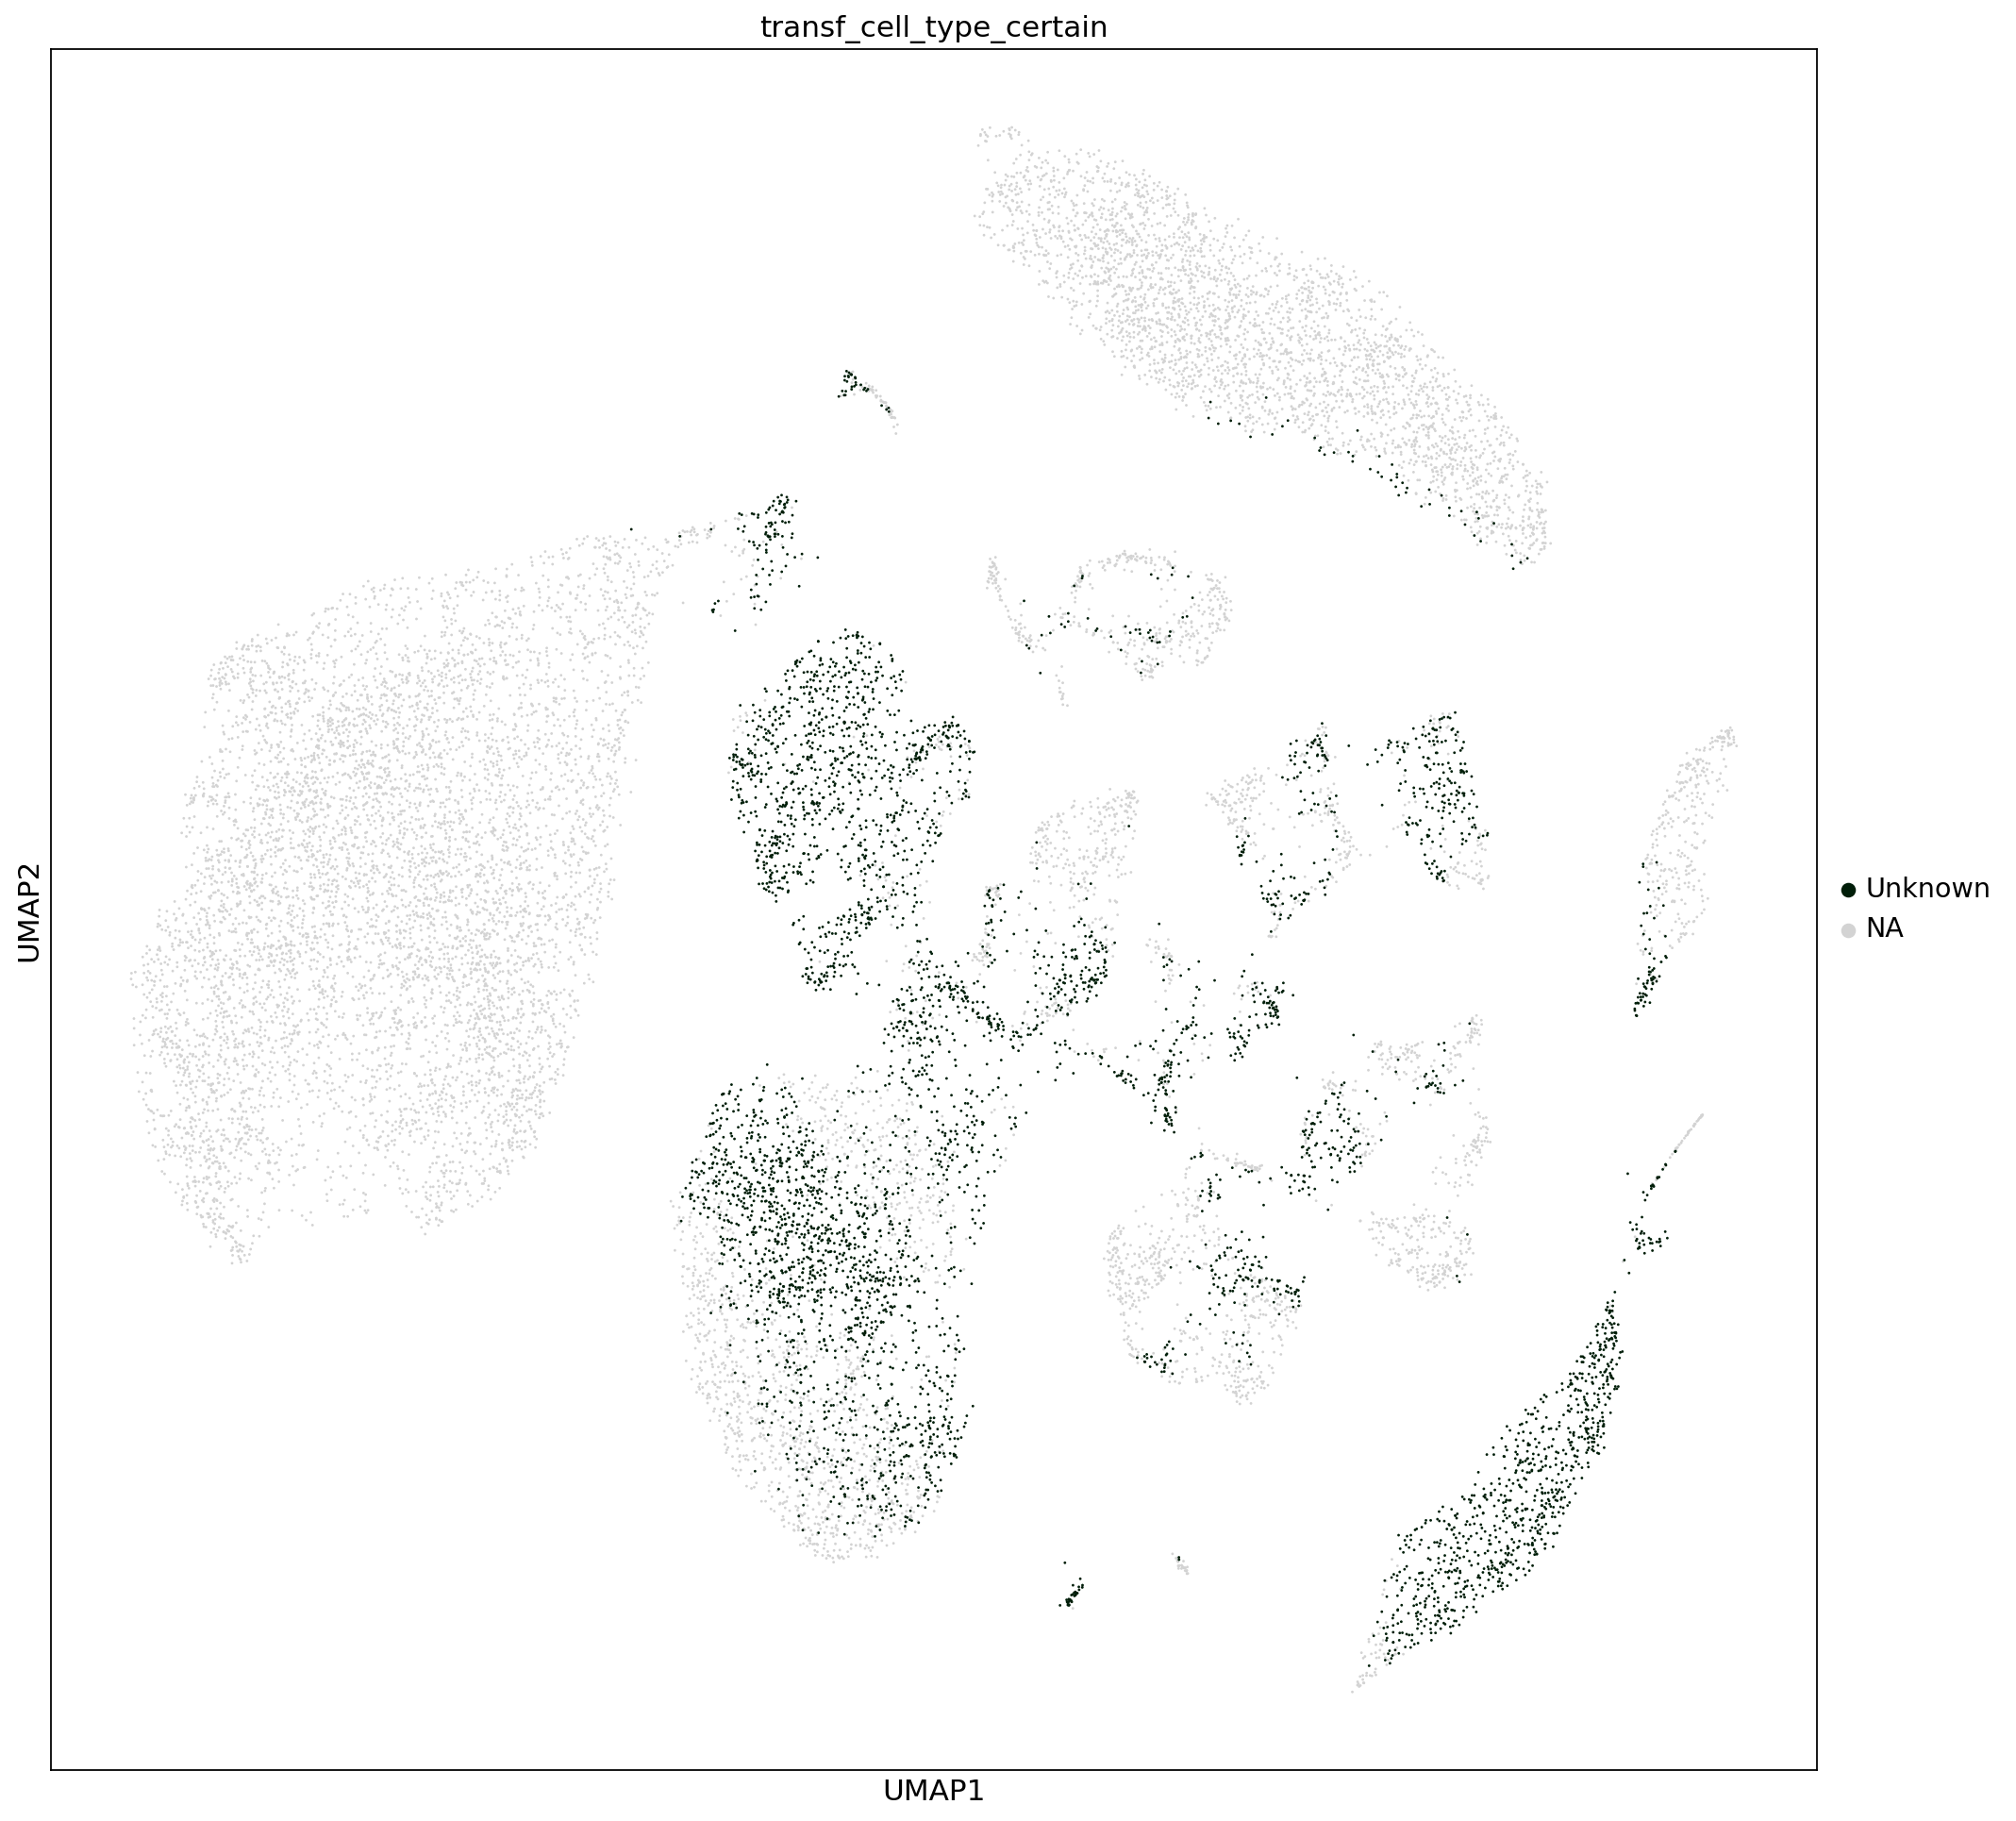

In [48]:
sc.pl.umap(adata, color="transf_cell_type_certain", groups="Unknown")

There are quite many of them! These cells will need particularly careful manual reviewing. However, the low-uncertainty annotations surrounding the "unknown cells" will already give us a first idea of what cell type we can expect each cell to belong to.

Now let's take a look at our more certain annotations. We will check for a few cell types (chosen at random here) to what extent the reference-transferred annotation matches our known marker genes from above. In reality, this should be done systematically for all annotations!

As you can see, the marker groups are generally most highly expressed in the cells annotated with the matching label. This means these labels are likely (at least partially) correct!

The uncertainty not only helps us identify regions where the algorithm is uncertain about which cell type a cell belongs to (e.g. because it falls in between two annotated phenotypes), but can also highlight unseen cell types or new cell states. For example, your reference might consist of healthy cells while your query could be from a diseased sample. The uncertainty score can then highlight disease-specific cell states, as they might not have neighbors from the reference that consistently come from a single cell type. Especially when your reference is based on a large set of datasets, the uncertainty score is useful to flag parts of the query data that could be interesting to look into. Reference-based label transfer thus not only helps you annotate your data, but can also speed up exploration and interpretation of your data. However, like any metric, these uncertainty scores are often not perfect and in some cases fail to highlight new cell types or states. For a more extensive discussion of uncertainty metrics, see e.g. {cite}`anno:Engelmann2019`.

Like with any of the methods discussed in this notebook, the quality of the transferred annotations depends on the quality of the "training data" (in this case the reference) and its annotations, the quality of the model, and the match of your own data with the training data! 

The quality of the transferred annotations should therefore always be validated with manual inspection using marker gene expression and refinement of the initial annotations might be needed. 

Finally, store your adata object if wanted:

In [49]:
adata.obs["transf_cell_type_unc"] = adata.obs["transf_cell_type_unc"].astype("float")

In [50]:
adata.write("analysis/MultiomeAnnotated.h5ad")
adata.obs.to_csv("analysis/MultiomeMetadataAnnotated.csv")

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: anno
```

## Contributors
We gratefully acknowledge the contributions of:
### Authors
- Lisa Sikkema
- Maren Büttner
### Reviewers
- Lukas Heumos